# Neural Network Model Training

In this notebook, we will simulate the glacier surface mass balance for the Iceland region using a neural network model. This model is designed with a custom objective function that generates monthly predictions based on aggregated observational data. We will create an instance of <code>CustomNeuralNetRegressor</code> and train it using this custom loss function on the stake data from Iceland, which we have prepared in earlier notebooks. If you haven't already, please review the [data preparation](https://github.com/ODINN-SciML/MassBalanceMachine/blob/main/notebooks/data_processing_wgms.ipynb) and [data preprocessing](https://github.com/ODINN-SciML/MassBalanceMachine/blob/main/notebooks/data_preprocessing.ipynb) notebooks for more details.

The workflow includes several key steps:
1. **Data Loading and Preparation:** A `Dataloader` object is created to handle the loading of data and the creation of a training and testing split.
2. **Model Training:** We train the model on the prepared data splits. This approach ensures a robust evaluation and helps in selecting suitable parameters.
3. **Aggregated Predictions:** After training, we will display the aggregated monthly predictions generated by the model to visualize and analyze the results.
4. **Model Evaluation:** Finally, the model's performance is evaluated on the test set, providing insights into its predictive accuracy for glacier mass balance.

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../')) # Add root of repo to import MBM

import pandas as pd
import massbalancemachine as mbm
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
from skorch.helper import SliceDataset
import torchsummary

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [2]:
data = pd.read_csv('./example_data/iceland/files/iceland_monthly_dataset.csv')
print('Number of winter and annual samples:', len(data))
display(data)

cfg = mbm.Config()

Number of winter and annual samples: 447


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,RGIId,POINT_ID,ID,N_MONTHS,MONTHS,aspect,slope,t2m,tp,slhf,sshf,ssrd,fal,str
0,1995,-18.773871,64.885013,2.07,1333.923612,-116.476388,RGI60-06.00228,hn14aa,0,7,oct,1.606406,0.056246,267.885682,0.005071,-32688.346894,1.908546e+05,3.434260e+06,0.850005,-1.029337e+06
1,1995,-18.773871,64.885013,2.07,1333.923612,-116.476388,RGI60-06.00228,hn14aa,0,7,nov,1.606406,0.056246,266.376346,0.006053,301104.083653,8.280538e+05,8.424995e+05,0.849992,-1.431540e+06
2,1995,-18.773871,64.885013,2.07,1333.923612,-116.476388,RGI60-06.00228,hn14aa,0,7,dec,1.606406,0.056246,263.049011,0.005854,248241.745197,9.954409e+05,1.322171e+05,0.849992,-2.002829e+06
3,1995,-18.773871,64.885013,2.07,1333.923612,-116.476388,RGI60-06.00228,hn14aa,0,7,jan,1.606406,0.056246,261.692810,0.004156,348585.225978,1.243700e+06,4.884578e+05,0.849992,-1.792889e+06
4,1995,-18.773871,64.885013,2.07,1333.923612,-116.476388,RGI60-06.00228,hn14aa,0,7,feb,1.606406,0.056246,261.140088,0.002287,274514.643950,1.004845e+06,2.580602e+06,0.850005,-1.861757e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,2018,-18.954942,64.662707,-2.63,1067.593874,246.593874,RGI60-06.00232,blt8,54,11,jun,2.889730,0.018996,276.144439,0.003192,10994.304045,6.234279e+05,1.787212e+07,0.768536,-9.177811e+05
443,2018,-18.954942,64.662707,-2.63,1067.593874,246.593874,RGI60-06.00232,blt8,54,11,jul,2.889730,0.018996,277.553280,0.003422,-589325.605420,7.537638e+04,1.425122e+07,0.676787,-7.246837e+05
444,2018,-18.954942,64.662707,-2.63,1067.593874,246.593874,RGI60-06.00232,blt8,54,11,aug,2.889730,0.018996,276.193729,0.002495,-807105.778219,-1.563324e+05,1.332676e+07,0.677706,-1.884936e+06
445,2018,-18.954942,64.662707,-2.63,1067.593874,246.593874,RGI60-06.00232,blt8,54,11,sep,2.889730,0.018996,273.151130,0.003491,-432479.565272,1.434597e+05,9.078256e+06,0.717923,-2.152404e+06


## 1. Create the train and test datasets

First, we create a `DataLoader` object, which generates both training and testing datasets, as well as the data splits required to evaluate the model on the validation set. To conserve memory, the `set_train_test_split` method returns iterators containing indices for the training and testing datasets. These indices are then used to retrieve the corresponding data for training and testing.

In [3]:
# Create a new DataLoader object with the monthly stake data measurements.
dataloader = mbm.dataloader.DataLoader(cfg, data=data)
# Create a training and testing iterators. The parameters are optional. The default value of test_size is 0.3.
train_itr, test_itr = dataloader.set_train_test_split(test_size=0.3)

# Get all indices of the training and testing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, test_indices = list(train_itr), list(test_itr)

# Get the features and targets of the training data for the indices as defined above, that will be used during the cross validation.
df_X_train = data.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get test set
df_X_test = data.iloc[test_indices]
y_test = df_X_test['POINT_BALANCE'].values

# Create the cross validation splits based on the training dataset. The default value for the number of splits is 5.
type_fold = 'group-meas-id'  # 'group-rgi' # or 'group-meas-id'
splits = dataloader.get_cv_split(n_splits=5, type_fold=type_fold)

# Print size of train and test
print(f"Size of training set: {len(train_indices)}")
print(f"Size of test set: {len(test_indices)}")

Size of training set: 296
Size of test set: 151


## 2. Create a `CustomNeuralNetRegressor` model

Next, we define the hyper-parameters to train the neural network. In the subsequent step, we use the validation set to assess the performance and explore hyper-parameters values and select the combination that yields the lowest loss. Additionally, we create a `CustomNeuralNetRegressor` object.

**Note:** the cross-validation tools are not supported by the neural network.

In [4]:
feature_columns = df_X_train.columns.difference(cfg.metaData)
feature_columns = feature_columns.drop(cfg.notMetaDataNotFeatures)
feature_columns = list(feature_columns)
nInp = len(feature_columns)
cfg.setFeatures(feature_columns)

class SimpleNetwork(nn.Module):
    def __init__(self, nNeurons, *args, **kwargs):
        assert len(nNeurons)>=2
        super().__init__(*args, **kwargs)
        layers = nn.Sequential(nn.Linear(nNeurons[0], nNeurons[1]))
        for i in range(1, len(nNeurons)-1):
            layers.append(nn.ReLU())
            layers.append(nn.Linear(nNeurons[i], nNeurons[i+1]))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(nNeurons[-1], 1))
        self.layers = layers
    def forward(self, x):
        return self.layers(x)
nNeurons = [nInp, 8]

# Create a CustomNeuralNetRegressor instance
params_init = {"device": "cpu"}
custom_nn = mbm.models.CustomNeuralNetRegressor(
    cfg,
    SimpleNetwork,
    nbFeatures=nInp,
    module__nNeurons=nNeurons,
    train_split=False, # train_split is disabled since cross validation is handled by the splits variable hereafter
    batch_size=16,
    verbose=0,
    iterator_train__shuffle=True,
    **params_init)

Now let's visualize the structure of our neural network:

In [5]:
torchsummary.summary(SimpleNetwork(nNeurons), input_size=(nInp,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 8]              88
              ReLU-2                    [-1, 8]               0
            Linear-3                    [-1, 1]               9
Total params: 97
Trainable params: 97
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Create datasets

In [6]:
features, metadata = mbm.data_processing.utils.create_features_metadata(cfg, df_X_train)

# Define the dataset for the NN
dataset = mbm.data_processing.AggregatedDataset(
    cfg,
    features=features,
    metadata=metadata,
    targets=y_train
)
splits = dataset.mapSplitsToDataset(splits)

# Use SliceDataset to make the dataset accessible as a numpy array for scikit learn
dataset = [SliceDataset(dataset, idx=0), SliceDataset(dataset, idx=1)]

print(dataset[0].shape, dataset[1].shape)

(38,) (38,)


## 3. Training

### 3.1. With hyper-parameters tuning

In the following cell, we begin training our model using either **GridSearchCV** or **RandomizedSearchCV**:

- **GridSearchCV** performs an exhaustive search across all possible parameter combinations to find the best set for optimal performance using cross-validation. While this method is thorough, it is often time-consuming and computationally expensive.
- **RandomizedSearchCV**, on the other hand, samples a fixed number of parameter combinations from the distribution, making it more efficient in terms of time and computational resources, especially with larger hyperparameter spaces. However, this approach may miss some of the best parameter combinations that aren't selected in the random sampling.

You can choose either of the two training methods. Both methods will use all CPU cores by default. If you want to adjust the number of cores used, you can change the `num_jobs` parameter in the `cfg` instance.

In [7]:
# For each of the XGBoost parameter, define the grid range
parameters = {
    'lr': [0.005, 0.001, 0.0005],
    'max_epochs': [1000, 2000],
    'optimizer': [torch.optim.Adam],
}

In [8]:
# GridSearch
custom_nn.gridsearch(parameters=parameters, splits=splits, features=dataset[0], targets=dataset[1])

# RandomisedSearch, with n_iter the number of parameter settings that are sampled. Trade-off between goodness of the solution
# versus runtime.
# custom_nn.randomsearch(
#     parameters=parameters,
#     n_iter=4,
#     splits=splits,
#     features=dataset[0],
#     targets=dataset[1],
# )
best_params = custom_nn.param_search.best_params_
best_estimator = custom_nn.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_nn.param_search.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters:
 {'lr': 0.005, 'max_epochs': 1000, 'optimizer': <class 'torch.optim.adam.Adam'>}
Best score:
 -0.4690324406226636


### 3.2. Standard training without hyper-parameters tuning

Alternatively, we could also train the network by using a set of prescribed hyper-parameters.
In this case the validation set is not used as no cross-validation is performed.
This standard training rely on the `fit` method.

In [9]:
# custom_nn.set_params(lr=0.0005, max_epochs=1000, optimizer=torch.optim.Adam)
# custom_nn.fit(dataset[0], dataset[1])

# best_estimator = custom_nn

### 3.1. Show the predictions

In [10]:
def predVSTruth(grouped_ids, mae, rmse, r2, title):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    legend_nn = "\n".join(
        (r"$\mathrm{MAE_{nn}}=%.3f, \mathrm{RMSE_{nn}}=%.3f, \mathrm{R_{nn}^2}=%.3f$ " % (
            mae,
            rmse,
            r2,
        ), ))

    marker_nn = 'o'
    sns.scatterplot(grouped_ids,
                    x="target",
                    y="pred",
                    ax=ax,
                    alpha=0.5,
                    marker=marker_nn)

    ax.set_ylabel('Predicted PMB [m w.e.]', fontsize=20)
    ax.set_xlabel('Observed PMB [m w.e.]', fontsize=20)

    ax.text(0.03,
            0.98,
            legend_nn,
            transform=ax.transAxes,
            verticalalignment="top",
            fontsize=20)
    ax.legend([], [], frameon=False)
    # diagonal line
    pt = (0, 0)
    ax.axline(pt, slope=1, color="grey", linestyle="-", linewidth=0.2)
    ax.axvline(0, color="grey", linestyle="-", linewidth=0.2)
    ax.axhline(0, color="grey", linestyle="-", linewidth=0.2)
    ax.grid()
    ax.set_title(title, fontsize=20)
    plt.tight_layout()

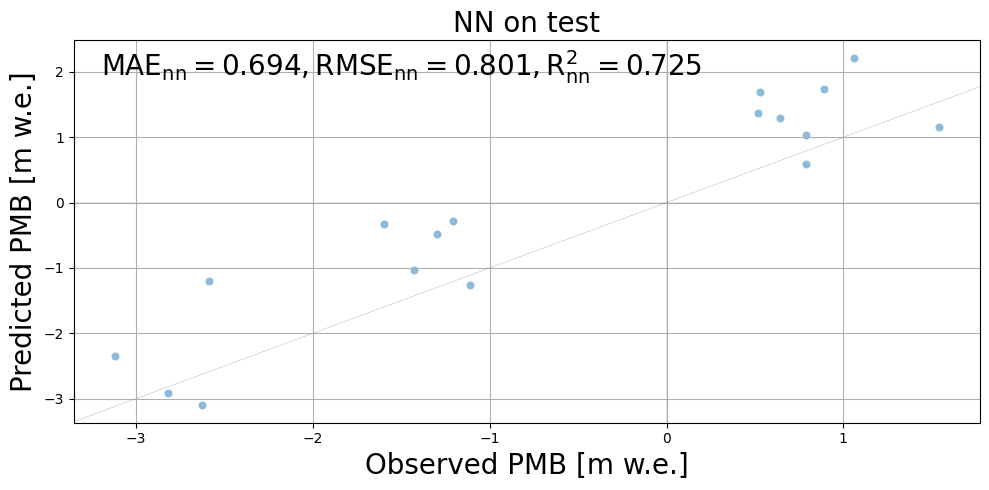

In [11]:
# Set to CPU for predictions:
best_nn = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = mbm.data_processing.utils.create_features_metadata(cfg, df_X_test)

dataset_test = mbm.data_processing.AggregatedDataset(
    cfg, features=features_test, metadata=metadata_test, targets=y_test)

dataset_test = [
    SliceDataset(dataset_test, idx=0),
    SliceDataset(dataset_test, idx=1)
]

# Make predictions aggr to meas ID
y_pred = best_nn.predict(dataset_test[0])
y_pred_agg = best_nn.aggrPredict(dataset_test[0])

batchIndex = np.arange(len(y_pred_agg))
y_true = np.array([e for e in dataset_test[1][batchIndex]])

# Calculate scores
score = best_nn.score(dataset_test[0], dataset_test[1])
mse, rmse, mae, pearson, r2, bias = best_nn.evalMetrics(y_pred, y_true)

# Aggregate predictions
id = dataset_test[0].dataset.indexToId(batchIndex)
data = {
    'target': [e[0] for e in dataset_test[1]],
    'ID': id,
    'pred': y_pred_agg
}
grouped_ids = pd.DataFrame(data)

predVSTruth(grouped_ids, mae, rmse, r2, title='NN on test')

### 3.2. Make cumulative predictions

In [12]:
def cumulativePredVSTruth(grouped_ids, title, month_abbr_hydr):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    marker_nn = 'o'
    sns.scatterplot(grouped_ids,
                    x="monthNb",
                    y="cum_pred",
                    hue="ID",
                    palette="YlOrBr",
                    ax=ax,
                    marker=marker_nn)

    ax.set_ylabel('Predicted cumulative PMB [m w.e.]', fontsize=15)
    ax.set_xlabel('Month', fontsize=15)

    plt.xticks(np.arange(1, 13), month_abbr_hydr.keys())

    ax.axvline(1, color="grey", linestyle="-", linewidth=0.2)
    ax.axhline(0, color="grey", linestyle="-", linewidth=0.2)
    ax.grid()
    ax.set_title(title, fontsize=18)
    plt.tight_layout()

In [13]:
y_cum_pred = best_nn.cumulative_pred(dataset_test[0])

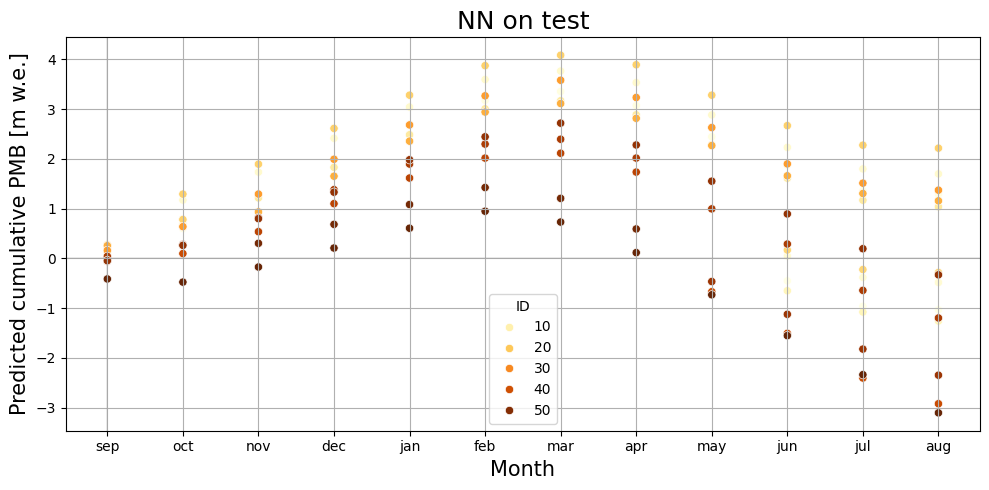

In [14]:
months = [
    dataset_test[0].dataset.indexToMetadata(index)
    [:, cfg.metaData.index('MONTHS')] for index in batchIndex
]
monthsNb = [[cfg.month_abbr_hydr[e] for e in l] for l in months]

ids = dataset_test[0].dataset.indexToId(batchIndex)
data = {'ID': [], 'cum_pred': [], 'monthNb': []}
for i, (id, mi) in enumerate(zip(ids, monthsNb)):
    yi_cum_pred = y_cum_pred[i][~np.isnan(y_cum_pred[i])]
    data['monthNb'] += mi
    data['cum_pred'] += yi_cum_pred.tolist()
    data['ID'] += [id] * len(mi)
df = pd.DataFrame(data)

cumulativePredVSTruth(df, 'NN on test', cfg.month_abbr_hydr)